# Using TubeInflation

In [1]:
import pymecht as pmt
import numpy as np
from matplotlib import pyplot as plt

Inflation-extension experiments can be simulated using the `TubeInflation` class in `SampleExperiment` module as demonstrated in this example.

## Displacement controlled

First, we use the `TubeInflation` in a simple `disp_controlled` manner. We start by creating a material and using it to create an experiment sample. Since GOH is an anisotropic material, fiber directions need to be specified before simulation (otherwise an error is raised). In `TubeInflation` cylinderical coordinates are used in the order of radius, angle, and longitudinal length. For the model to be valid, the fiber directions need to be axially symmetric, which means they should not have a radial component, and should be symmetric about the circumferential axis. This can be automatically satisfied by using the helper function, which sets the same fiber directions to all material model components, as below.

In [2]:
mat_model = pmt.MatModel('Yeoh','goh')
sample = pmt.TubeInflation(mat_model)
pmt.specify_two_fibers(sample,10)
params = sample.parameters
print(sample,params)

Fiber directions set to  10  degrees ( 0.17453292519943295  radians)
An object of type TubeInflationwith radius as input, pressure as output, and the following material
Material model with 2 components:
Component1: YEOH with fiber direction(s):[array([0.        , 0.98480775, 0.17364818]), array([ 0.        ,  0.98480775, -0.17364818])]
Component2: GOH with fiber direction(s):[array([0.        , 0.98480775, 0.17364818]), array([ 0.        ,  0.98480775, -0.17364818])]
 ------------------------------------------------------------------
Keys              Value       Fixed?      Lower bound Upper bound 
------------------------------------------------------------------
Ri                1.00        No          0.50        1.50        
thick             0.10        No          0.00        1.00        
omega             0.00        No          0.00        0.00        
L0                1.00        No          1.00        1.00        
lambdaZ           1.00        No          1.00        1.00

By default, the displacement measure (input) is radius and the force measure (output) is pressure. Moreover, we can see that the sample parameters include geometric ones (radius, thickness, length, opening angle omega, and longitudinal stretch lambdaZ) in addition to the material parameters. Next we set the parameter values.

In [3]:
params.set('Ri', 9) 
params.set('thick', 2)
params.set('omega', 0)
params.set('L0', 1)
params.set('lambdaZ', 1)
params.set('c1_0', 28)
params.set('c2_0', 21)
params.set('c3_0', 8)
params.set('c4_0', 1)
params.set('k1_1',5.)
params.set('k2_1',15)
params.set('k3_1',0.1)
print(params)

------------------------------------------------------------------
Keys              Value       Fixed?      Lower bound Upper bound 
------------------------------------------------------------------
Ri                9.00        No          0.50        1.50        
thick             2.00        No          0.00        1.00        
omega             0.00        No          0.00        0.00        
L0                1.00        No          1.00        1.00        
lambdaZ           1.00        No          1.00        1.00        
c1_0              28.00       No          1.00e-04    1.00e+02    
c2_0              21.00       No          0.00        1.00e+02    
c3_0              8.00        No          0.00        1.00e+02    
c4_0              1.00        No          0.00        1.00e+02    
k1_1              5.00        No          0.10        30.00       
k2_1              15.00       No          0.10        30.00       
k3_1              0.10        No          0.00        0.33    

and fix certain parameters (for the parameter fitting etc.).

In [4]:
params.fix('Ri')
params.fix('thick')
params.fix('omega')
params.fix('L0')
params.fix('lambdaZ')
print(params)

------------------------------------------------------------------
Keys              Value       Fixed?      Lower bound Upper bound 
------------------------------------------------------------------
Ri                9.00        Yes         -           -           
thick             2.00        Yes         -           -           
omega             0.00        Yes         -           -           
L0                1.00        Yes         -           -           
lambdaZ           1.00        Yes         -           -           
c1_0              28.00       No          1.00e-04    1.00e+02    
c2_0              21.00       No          0.00        1.00e+02    
c3_0              8.00        No          0.00        1.00e+02    
c4_0              1.00        No          0.00        1.00e+02    
k1_1              5.00        No          0.10        30.00       
k2_1              15.00       No          0.10        30.00       
k3_1              0.10        No          0.00        0.33    

Then we perform the simulation by specifying the deformed internal radius in the `disp_controlled` method.

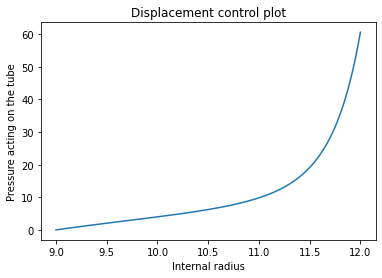

In [5]:
from matplotlib import pyplot as plt
def_radius = np.linspace(9,12,100)
plt.plot(def_radius,sample.disp_controlled(def_radius,params)) 
plt.ylabel('Pressure acting on the tube')
plt.xlabel('Internal radius')
plt.title('Displacement control plot')
plt.show()

## Force controlled

Inversely, one can specify the force acting on the tube and calculate the deformed internal radius using `force_controlled` method.

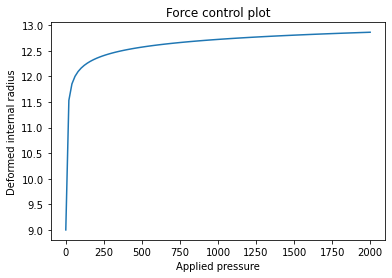

In [6]:
from matplotlib import pyplot as plt
force = np.linspace(0,2000,100)
plt.plot(force,sample.force_controlled(force,params)) 
plt.ylabel('Deformed internal radius')
plt.xlabel('Applied pressure')
plt.title('Force control plot')
plt.show()

Note that `force_controlled` uses iterative solver, evaluating the `disp_controlled` simulation multiple times to find the “displacement” that would result in the applied force (numerically close-enough). Thus, `force_controlled` is commonly slower than `disp_controlled`.

## Stress across the thickness

Since the induced stress in a cylinder is non-uniform, we can calculate it using the `cauchy_stress` method. It takes the `disp_measure` (by default the deformed inner radius) of the tube and the parameters. The output is a tuple of the normalised thickness `xi` which has by default 10 points, and stress tensors `stress` which is a list of the stress tensors at these locations across the thickness.

In [7]:
xi,stress = sample.cauchy_stress([10], params)
print(type(xi), type(stress))
print(len(xi), len(stress))
print(stress[0].shape)

<class 'numpy.ndarray'> <class 'list'>
10 10
(3, 3)


For visualisation, we plot the von-Mises stress at each point across the thickness.

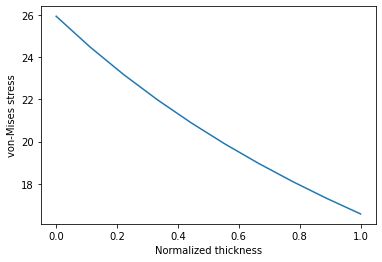

In [8]:
def von_mises(sigma_list):
    return [sqrt(3./2.)*np.linalg.norm(sigma-np.trace(sigma)/3.*np.eye(3)) for sigma in sigma_list]

plt.plot(xi,von_mises(stress))
plt.xlabel('Normalized thickness')
plt.ylabel('von-Mises stress')
plt.show()

## Different `force_measure`s

There are two options for the `force_measure` argument, as we can see from the helper function.

In [9]:
pmt.TubeInflation?

Init signature:
pmt.TubeInflation(
    mat_model,
    disp_measure='radius',
    force_measure='pressure',
)
Docstring:     
For simulating uniform axisymmetric inflation of a tube

+-----------+-----------------------------+
| Parameter | Description (default)       |
+===========+=============================+
| Ri        | Internal radius (1)         |
+-----------+-----------------------------+
| thick     | Thickness (0.1)             |
+-----------+-----------------------------+
| omega     | Opening angle (radians) (0) |
+-----------+-----------------------------+
| L0        | Length of sample (1)        |
+-----------+-----------------------------+
| lambdaZ   | Longitudinal stretch (1)    |
+-----------+-----------------------------+

Parameters
----------
mat_model: MatModel
    A material model object of type MatModel
disp_measure: str
    The measure of displacement with the following options:    
    
    * 'stretch' : Ratio of deformed to reference internal radius
    * 

In [10]:
#output pressure (by default)
sample = pmt.TubeInflation(mat_model,force_measure='pressure')
params.set('L0',1)
print(sample.disp_controlled(10,params)) #prints presssure at a deformed radius of 10

params.set('L0',2)
print(sample.disp_controlled(10,params)) #the pressure remains unchanged

4.008308115330826
4.008308115330826


In [11]:
#output force, which depends on the length of the tube
sample = pmt.TubeInflation(mat_model,force_measure='force')
params.set('L0',1)
print(sample.disp_controlled(10,params)) #prints force at a deformed radius of 10, which depends on the reference radius and length of the sample

params.set('L0',2)
print(sample.disp_controlled(10,params)) #see the new force, which should be twice

251.84942656895345
503.6988531379069


## Different `disp_measure`s

There are four options for the `disp_measure` argument, as we can see from the helper function above. Thus, one can use different ones when creating the sample. This will result in different outputs from `force_controlled`. Similarly, the inputs to the `disp_controlled` will be treated as the chosen `disp_measure`.

When using `force_controlled` simulation, an iterative solution is involved, for which an initial guess is required. There is a default value, which may not be reasonable for different `disp_measure`s. Thus, we can explicitly specify the initial guess using `x0` argument.

In [12]:
sample2 = pmt.TubeInflation(mat_model, disp_measure='stretch', force_measure='pressure')
print('stretch', sample2.force_controlled(10,params,x0=1))

sample2 = pmt.TubeInflation(mat_model, disp_measure='deltar', force_measure='pressure')
print('deltar', sample2.force_controlled(10,params,x0=0))

sample2 = pmt.TubeInflation(mat_model, disp_measure='radius', force_measure='pressure')
print('radius', sample2.force_controlled(10,params,x0=params['Ri'].value))

sample2 = pmt.TubeInflation(mat_model, disp_measure='area', force_measure='pressure')
area = np.pi*(params['Ri'].value)**2 #calculates the lumen area
print('area', sample2.force_controlled(10,params,x0=area))

stretch 1.2239472787140655
deltar 2.0155255084265886
radius 11.015525508426588
area 381.2065144490343


## Fiber direction warning

One can manually specify the fiber direction in the material models before using them to create a `TubeInflation` sample, as follows.

In [13]:
mat = pmt.MatModel('yeoh','goh')
mat_models = mat.models
mat_models[1].fiber_dirs = np.array([0,1,1])
sample = pmt.TubeInflation(mat)
print(sample)

An object of type TubeInflationwith radius as input, pressure as output, and the following material
Material model with 2 components:
Component1: YEOH
Component2: GOH with fiber direction(s):[array([0.        , 0.70710678, 0.70710678])]



/usr/local/lib/python3.9/site-packages/pymecht/SampleExperiment.py:536: UserWarning: The TubeInflation assumes that fibers are symmetric w.r.t. axes. This is not satisfied and the results may be spurious.
  warnings.warn("The TubeInflation assumes that fibers are symmetric w.r.t. axes. This is not satisfied and the results may be spurious.")


However, it raises a warning that the fiber directions are not symmetric with respect to the coordinate system, which means there are shear stresses that are being ignored during the simulation. Therefore, to avoid such issues, helper functions `specifiy_single_fiber` and `specify_two_fibers` are provided.

## Least square fitting

One can also use `TubeInflation` instance to perform parameter fitting as demonstrated below. More details on this are provided in the "Using ParamFitter" example.

In [14]:
applied_radius = np.linspace(9,12,20)
measured_pressure = np.linspace(0,10,20)

sample = pmt.TubeInflation(mat_model, force_measure='pressure')
pmt.specify_two_fibers(sample,10)

def sim_func(param):
    return sample.disp_controlled(applied_radius,param)

param_fitter = pmt.ParamFitter(sim_func,measured_pressure,params)

Fiber directions set to  10  degrees ( 0.17453292519943295  radians)
Parameter fitting instance created with the following settings
------------------------------------------------------------------
Keys              Value       Fixed?      Lower bound Upper bound 
------------------------------------------------------------------
Ri                9.00        Yes         -           -           
thick             2.00        Yes         -           -           
omega             0.00        Yes         -           -           
L0                2.00        Yes         -           -           
lambdaZ           1.00        Yes         -           -           
c1_0              28.00       No          1.00e-04    1.00e+02    
c2_0              21.00       No          0.00        1.00e+02    
c3_0              8.00        No          0.00        1.00e+02    
c4_0              1.00        No          0.00        1.00e+02    
k1_1              5.00        No          0.10        30.00     

In [15]:
res = param_fitter.fit()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.0177e+03                                    2.95e+04    
       1              2         3.1888e+02      1.70e+03       4.40e+00       4.18e+03    
       2              3         4.5504e+01      2.73e+02       2.56e+00       5.99e+02    
       3              4         6.7995e+00      3.87e+01       1.64e+00       9.19e+01    
       4              5         1.2549e+00      5.54e+00       2.33e+00       1.72e+01    
       5              6         3.0985e-01      9.45e-01       1.61e+00       5.45e+00    
       6              7         1.5975e-01      1.50e-01       1.88e+00       2.60e+00    
       7              8         1.1851e-01      4.12e-02       3.71e+00       2.81e+00    
       8              9         9.1492e-02      2.70e-02       2.38e+00       1.29e+00    
       9             10         7.8419e-02      1.31e-02       2.86e+00       1.06e+00    

In [16]:
print(params)

------------------------------------------------------------------
Keys              Value       Fixed?      Lower bound Upper bound 
------------------------------------------------------------------
Ri                9.00        Yes         -           -           
thick             2.00        Yes         -           -           
omega             0.00        Yes         -           -           
L0                2.00        Yes         -           -           
lambdaZ           1.00        Yes         -           -           
c1_0              13.18       No          1.00e-04    1.00e+02    
c2_0              1.03e-48    No          0.00        1.00e+02    
c3_0              4.50e-40    No          0.00        1.00e+02    
c4_0              4.07e-39    No          0.00        1.00e+02    
k1_1              30.00       No          0.10        30.00       
k2_1              0.10        No          0.10        30.00       
k3_1              0.13        No          0.00        0.33    

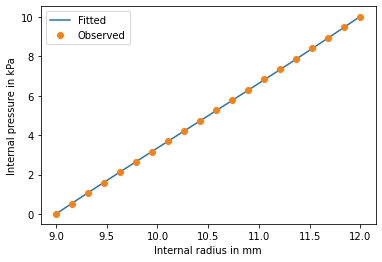

In [17]:
plt.plot(applied_radius,sample.disp_controlled(applied_radius,params),label='Fitted') 
plt.plot(applied_radius,measured_pressure,'o',label='Observed')
plt.ylabel('Internal pressure in kPa')
plt.xlabel('Internal radius in mm')
plt.legend()
plt.show()